In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.linear_model import Ridge
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_init = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
test_info = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
test_init = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')

In [3]:
# prepare train
feat_map = train_init.groupby('Patient')['Weeks'].first()
train_init['init_Week'] = train_init['Patient'].map(feat_map)
feat_map = train_init.groupby('Patient')['FVC'].first()
train_init['init_FVC'] = train_init['Patient'].map(feat_map)
feat_map = train_init.groupby('Patient')['Percent'].first()
train_init['init_Percent'] = train_init['Patient'].map(feat_map)

train_init.drop(['Percent'], axis=1, inplace=True)
train_init = train_init[train_init.Weeks!=train_init.init_Week].reset_index(drop=True)
feats = [col for col in train_init.columns if col not in ['Patient', 'FVC']]
target = ['FVC']

In [4]:
# prepare test data
test_info.rename(columns={'FVC':'init_FVC', 'Weeks':'init_Week', 'Percent':'init_Percent'}, inplace=True)
test_init['Patient'] = test_init['Patient_Week'].apply(lambda x:x.split('_')[0])
test_init['Weeks'] = test_init['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
test_init = test_init.merge(test_info, on='Patient', how='left')
test_init.drop(['Patient_Week', 'FVC', 'Confidence'], axis=1, inplace=True)
test_init = test_init[feats]

In [5]:
# feed pandas series of targets
# feed numpy array of confidence scores and oof predictions
def score(true, pred, conf, scored):
    df = pd.DataFrame(data=true, columns=['FVC'])
    df['FVC_pred'] = pred
    df['Confidence'] = conf
    df['scored'] = scored
    df = df[df.scored==1]
    
    df['sigma_clipped'] = df['Confidence'].apply(lambda x: max(x, 70))
    df['diff'] = abs(df['FVC'] - df['FVC_pred'])
    df['delta'] = df['diff'].apply(lambda x: min(x, 1000))
    df['score'] = -np.sqrt(2)*df['delta']/df['sigma_clipped'] - np.log(np.sqrt(2)*df['sigma_clipped'])
    return df['score'].mean()

In [6]:
# feature encoding and further feature engineering
def create_features(df, test_df):
    for col in ['Sex', 'SmokingStatus']:
        le = LabelEncoder()
        le.fit(list(df[col].astype(str).values) + list(test_df[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))
        test_df[col] = le.transform(list(test_df[col].astype(str).values))
    
    df_concat = pd.concat([df, test_df])
    
    df_concat['Weeks_passed'] = df_concat['Weeks'] - df_concat['init_Week']
    df_concat.drop(['Weeks', 'init_Week'], axis=1, inplace=True)
    
    test_df = df_concat[len(df):]
    df = df_concat[:len(df)]
    
    return df, test_df

In [7]:
# mean and std removal
def normalize(df, test_df, features):
    df, test_df = df.copy(), test_df.copy()
    norm_feats = [feat for feat in features if feat not in ['SmokingStatus', 'Sex']]
    for feat in norm_feats:
        mean = df[feat].mean()
        std = df[feat].std()
        
        df[feat] = (df[feat]-mean)/std
        test_df[feat] = (test_df[feat]-mean)/std
    
    return df, test_df

In [8]:
def more_feats(df, test_df, feats):
    df_concat = pd.concat([df, test_df])
    
    df_concat['age_perc_ratio'] = df_concat['init_Percent'] / df_concat['Age']
    df_concat['sex_smoke'] = df_concat['Sex'] - df_concat['SmokingStatus']
    df_concat['fvc_age_diff'] = df_concat['init_FVC'] - df_concat['Age']
    feats.extend(['age_perc_ratio', 'sex_smoke', 'fvc_age_diff'])

    test_df = df_concat[len(df):]
    df = df_concat[:len(df)]
    
    return df, test_df, feats

In [9]:
train_init, test_init = create_features(train_init, test_init)

# redefine feats after feature engineering
feats = [col for col in train_init.columns if col not in ['Patient', 'FVC']]
target = ['FVC']

In [10]:
# init placeholders and vars for confidence scores
base_confidence = 200
var_confidence = 2
temp_confs = np.ones(len(train_init)) * base_confidence
temp_confs_test = np.ones(len(test_init)) * base_confidence

In [11]:
# create confidence scores --> base_confidence + weeks passed * var confidence
train_init['confs'] = temp_confs + train_init['Weeks_passed'] * var_confidence
temp_confs = train_init.confs.values
train_init.drop('confs', axis=1, inplace=True)

test_init['confs'] = temp_confs_test + test_init['Weeks_passed'] * var_confidence
temp_confs_test = test_init.confs.values
test_init.drop('confs', axis=1, inplace=True)

In [12]:
# mean std removal and some interaction features
train, test = normalize(train_init, test_init, feats)
train, test, feats = more_feats(train, test, feats)

In [13]:
train[feats]

,Age,Sex,SmokingStatus,init_FVC,init_Percent,Weeks_passed,age_perc_ratio,sex_smoke,fvc_age_diff
0,1.672216,1,1,-0.564523,-1.147615,-0.612444,-0.686284,0,-2.236739
1,1.672216,1,1,-0.564523,-1.147615,-0.498266,-0.686284,0,-2.236739
2,1.672216,1,1,-0.564523,-1.147615,-0.384088,-0.686284,0,-2.236739
3,1.672216,1,1,-0.564523,-1.147615,-0.269910,-0.686284,0,-2.236739
4,1.672216,1,1,-0.564523,-1.147615,0.072625,-0.686284,0,-2.236739
...,...,...,...,...,...,...,...,...,...
1362,0.823063,1,2,0.163256,-0.446957,-0.384088,-0.543041,-1,-0.659808
1363,0.823063,1,2,0.163256,-0.446957,-0.041553,-0.543041,-1,-0.659808
1364,0.823063,1,2,0.163256,-0.446957,0.643515,-0.543041,-1,-0.659808
1365,0.823063,1,2,0.163256,-0.446957,1.328583,-0.543041,-1,-0.659808


In [14]:
seed = 42
alpha = 1000
num_folds = 5
kf = GroupKFold(num_folds)
coefs = []
pp_coef = 1.00 # optimize by weeks passed corrected for init fvc?

oof = np.zeros(len(train))
preds = np.zeros((len(test), num_folds))
score_indices = train.groupby('Patient').tail(3).index.values # used to select only last 3 entries for scoring during validation
score_mask = np.zeros(len(train))
score_mask[score_indices] += 1

In [15]:
for fold, (train_idx, val_idx) in enumerate(kf.split(train, train, groups=train.Patient)):
    xtrain, xval = train.iloc[train_idx], train.iloc[val_idx]
    # get initial fvc values for each patient
    xtrain_fvc = train_init.iloc[train_idx]['init_FVC']
    xval_fvc = train_init.iloc[val_idx]['init_FVC']
    xtest_fvc = test_init['init_FVC']
    
    # use difference to initial fvc values as target
    xtrain[target] = xtrain[target].values.flatten() - xtrain_fvc.values.flatten()
    model = Ridge(alpha=alpha, normalize=False)
    model.fit(xtrain[feats], xtrain[target])
    coefs.append(model.coef_)
    
    # prediction = init fvc + predicted delta by model
    oof[val_idx] = (model.predict(xval[feats]).flatten() + xval_fvc) * pp_coef
    preds[:, fold] = (model.predict(test[feats]).flatten() + xtest_fvc) * pp_coef
    
    score_fold = score(xval[target], oof[val_idx], temp_confs[val_idx], score_mask[val_idx])
    print("Fold {} score without optimized confidence: ".format(fold+1), np.round(score_fold, 4))

Fold 1 score without optimized confidence:  -6.947
Fold 2 score without optimized confidence:  -6.9419
Fold 3 score without optimized confidence:  -7.163
Fold 4 score without optimized confidence:  -6.9393
Fold 5 score without optimized confidence:  -6.9276


In [16]:
coefs = np.concatenate(coefs)
coefs = np.mean(coefs, axis=0)
coefs_dict = {feats[i]:coefs[i] for i in range(len(feats))}

In [17]:
coefs_dict

{'Age': -5.444099676602934,
 'Sex': -2.424797530788386,
 'SmokingStatus': -2.7156403955191273,
 'init_FVC': -13.21529901957706,
 'init_Percent': -5.899179855158419,
 'Weeks_passed': -31.050152102954524,
 'age_perc_ratio': 1.8313463795052685,
 'sex_smoke': 0.29084286473074006,
 'fvc_age_diff': -7.771199342974119}

In [18]:
preds = np.mean(preds, axis=1)
score_init = score(train[target], oof, temp_confs, score_mask)
print("Score without optimized confidence: ", np.round(score_init, 4))

Score without optimized confidence:  -6.9848


In [19]:
#train_init['FVC_pred'] = oof
#test_init['FVC_pred'] = preds

In [20]:
# postprocessing for out of distribution samples --> not working for now, no difference in LB score whatsoever
# --> either no such samples in the test set or buggy
# test.loc[test.Weeks_passed < train.Weeks_passed.min(), 'FVC_pred'] = test.FVC_pred * .99
# preds = test.FVC_pred.values

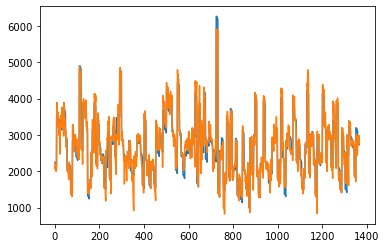

In [21]:
pd.Series(oof).plot()
train.FVC.plot()

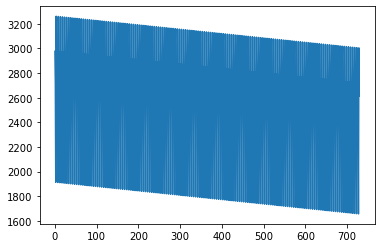

In [22]:
pd.Series(preds).plot()

In [23]:
# postprocessing based on 0 weeks passed --> max confidence and set FVC to init FVC instead of prediction
test_init['FVC_pred'] = preds
test_init['conf'] = temp_confs_test

test_init.loc[test_init.Weeks_passed==0, 'conf'] = 70.0
test_init.loc[test_init.Weeks_passed==0, 'FVC_pred'] = test_init[test_init.Weeks_passed==0]['init_FVC']

preds = test_init.FVC_pred.values
temp_confs_test = test_init.conf.values

In [24]:
sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')
sub['FVC'] = preds
sub['Confidence'] = temp_confs_test

In [25]:
sub.to_csv('submission.csv', index=False)

In [26]:
sub

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2976.874889,164.0
1,ID00421637202311550012437_-12,2716.068875,146.0
2,ID00422637202311677017371_-12,1912.936678,164.0
3,ID00423637202312137826377_-12,3261.433789,142.0
4,ID00426637202313170790466_-12,2870.300601,176.0
...,...,...,...
725,ID00419637202311204720264_133,2719.844553,454.0
726,ID00421637202311550012437_133,2459.038539,436.0
727,ID00422637202311677017371_133,1655.906342,454.0
728,ID00423637202312137826377_133,3004.403453,432.0
